In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
torch.manual_seed(42)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
train = pd.read_csv('data/Train.csv')
test = pd.read_csv('data/Test.csv')
val = pd.read_csv('data/Valid.csv')

In [5]:
df = pd.concat([train, test, val]).reset_index(drop=True)

In [6]:
def tokenize_text(text, tokenizer, max_length=512):
    """
    Tokenize text using BERT tokenizer
    """
    return tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_length,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

In [7]:
def prepare_data(texts, labels, tokenizer, batch_size=16):
    """
    Prepare data for model training
    """
    all_input_ids = []
    all_attention_masks = []
    
    for text in tqdm(texts, desc="Tokenizing texts"):
        encoded = tokenize_text(str(text), tokenizer)
        all_input_ids.append(encoded['input_ids'])
        all_attention_masks.append(encoded['attention_mask'])
    
    all_input_ids = torch.cat(all_input_ids, dim=0)
    all_attention_masks = torch.cat(all_attention_masks, dim=0)
    all_labels = torch.tensor(labels, dtype=torch.long)
    
    # Create TensorDataset
    dataset = torch.utils.data.TensorDataset(
        all_input_ids, 
        all_attention_masks, 
        all_labels
    )
    
    # Create DataLoader
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True
    )
    
    return dataloader

In [8]:
def initialize_model():
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=2
    ).to(device)
    optimizer = AdamW(model.parameters(), lr=2e-5)
    
    return model, tokenizer, optimizer

In [9]:
def train_epoch(model, data_loader, optimizer):
    """
    Train model for one epoch
    """
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    
    progress_bar = tqdm(data_loader, desc="Training")
    
    for batch in progress_bar:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)
        
        optimizer.zero_grad()
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        logits = outputs.logits
        
        _, predictions = torch.max(logits, dim=1)
        
        correct_predictions += torch.sum(predictions == labels)
        total_predictions += len(labels)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # Update progress bar
        progress_bar.set_postfix({
            'loss': f'{total_loss/(progress_bar.n+1):.3f}',
            'accuracy': f'{correct_predictions/total_predictions:.3f}'
        })
    
    return total_loss / len(data_loader), correct_predictions.float() / total_predictions

In [10]:
def evaluate(model, data_loader):
    """
    Evaluate model on validation/test data
    """
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            logits = outputs.logits
            
            _, predictions = torch.max(logits, dim=1)
            
            correct_predictions += torch.sum(predictions == labels)
            total_predictions += len(labels)
            total_loss += loss.item()
    
    return total_loss / len(data_loader), correct_predictions.float() / total_predictions


In [11]:
def train_model(model, train_loader, val_loader, optimizer, epochs=3):
    """
    Complete training loop
    """
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(epochs):
        print(f'\nEpoch {epoch + 1}/{epochs}')
        
        # Training
        train_loss, train_acc = train_epoch(model, train_loader, optimizer)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc.cpu().numpy())
        
        # Validation
        val_loss, val_acc = evaluate(model, val_loader)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc.cpu().numpy())
        
        print(f'Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.3f}')
        print(f'Val Loss: {val_loss:.3f}, Val Accuracy: {val_acc:.3f}')
    
    return train_losses, train_accuracies, val_losses, val_accuracies

In [12]:
def plot_training_history(train_losses, train_accuracies, val_losses, val_accuracies):
    """
    Plot training and validation metrics
    """
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Loss over time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Val Accuracy')
    plt.title('Accuracy over time')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [13]:
def predict_sentiment(text, model, tokenizer):
    """
    Predict sentiment for a single text input
    """
    model.eval()
    encoding = tokenize_text(text, tokenizer)
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, prediction = torch.max(outputs.logits, dim=1)
    
    return "Positive" if prediction[0] == 1 else "Negative"

In [14]:
# Initialize model and tokenizer
model, tokenizer, optimizer = initialize_model()

# Split data
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['text'].values, 
    df['label'].values, 
    test_size=0.1, 
    random_state=42
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, 
    temp_labels, 
    test_size=0.5, 
    random_state=42
)

# Prepare data loaders
print("Preparing training data...")
# I used 5000 instead of 50000 to speed up the training
train_loader = prepare_data(train_texts[:5000], train_labels[:5000], tokenizer)
print("Preparing validation data...")
val_loader = prepare_data(val_texts, val_labels, tokenizer)
print("Preparing test data...")
test_loader = prepare_data(test_texts, test_labels, tokenizer)

# Train model
history = train_model(model, train_loader, val_loader, optimizer)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Preparing training data...


Tokenizing texts: 100%|██████████| 5000/5000 [00:20<00:00, 246.29it/s]


Preparing validation data...


Tokenizing texts: 100%|██████████| 2500/2500 [00:10<00:00, 237.63it/s]


Preparing test data...


Tokenizing texts: 100%|██████████| 2500/2500 [00:09<00:00, 251.70it/s]



Epoch 1/3


Evaluating: 100%|██████████| 157/157 [01:34<00:00,  1.66it/s]


Train Loss: 0.312, Train Accuracy: 0.861
Val Loss: 0.239, Val Accuracy: 0.907

Epoch 2/3


Evaluating: 100%|██████████| 157/157 [01:33<00:00,  1.68it/s]


Train Loss: 0.129, Train Accuracy: 0.958
Val Loss: 0.224, Val Accuracy: 0.917

Epoch 3/3


Evaluating: 100%|██████████| 157/157 [01:45<00:00,  1.48it/s]

Train Loss: 0.059, Train Accuracy: 0.983
Val Loss: 0.323, Val Accuracy: 0.915


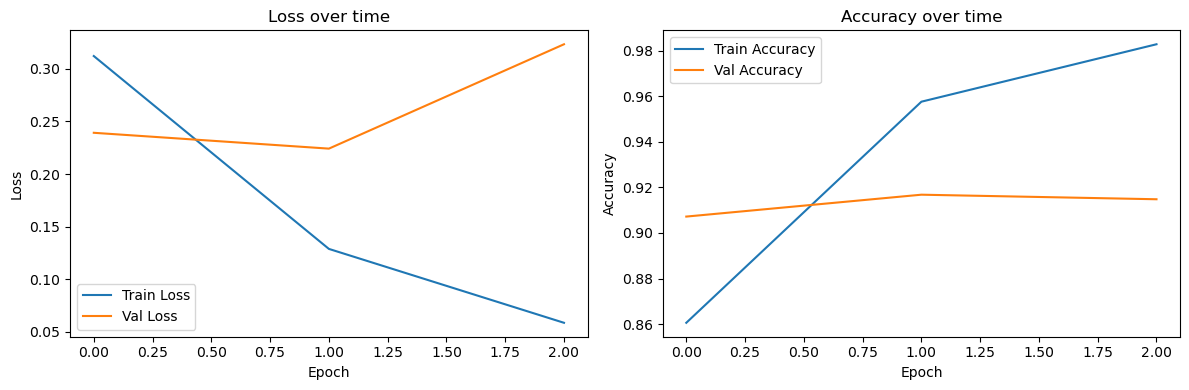

Evaluating: 100%|██████████| 157/157 [01:47<00:00,  1.46it/s]


Test Loss: 0.285, Test Accuracy: 0.920


In [15]:
# Plot results
plot_training_history(*history)

# Evaluate on test set
test_loss, test_acc = evaluate(model, test_loader)
print(f'\nTest Loss: {test_loss:.3f}, Test Accuracy: {test_acc:.3f}')

In [16]:
# Example predictions
example_texts = [
    "This movie was absolutely fantastic!",
    "What a terrible waste of time and money.",
    "The acting was good but the plot was confusing."
]

for text in example_texts:
    sentiment = predict_sentiment(text, model, tokenizer)
    print(f"\nText: {text}")
    print(f"Sentiment: {sentiment}")


Text: This movie was absolutely fantastic!
Sentiment: Positive

Text: What a terrible waste of time and money.
Sentiment: Negative

Text: The acting was good but the plot was confusing.
Sentiment: Negative


In [18]:
torch.save(model.state_dict(), 'bert_sentiment_model.pt')